In [1]:
import os
import itertools
import shutil
import pathlib
from PIL import Image

#data handling tools
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files

files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [01:30<00:00, 23.9MB/s]
100% 1.76G/1.76G [01:30<00:00, 20.8MB/s]


In [5]:
import zipfile

with zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


In [6]:
data_dir = r'/content/lung_colon_image_set'

filepaths = []
labels = []


for root, dirs, files in os.walk(data_dir):
    for kelas in dirs:
        if kelas in ["lung_image_sets", "colon_image_sets"]:
            continue  # Skip the main classes, only consider subclasses
        classpath = os.path.join(root, kelas)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(kelas)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  # Make a combined dataframe

print(df['labels'].value_counts())

colon_aca    5000
colon_n      5000
lung_scc     5000
lung_n       5000
lung_aca     5000
Name: labels, dtype: int64


In [7]:
#Split data into train 80%
train, dummy = train_test_split(df , train_size = 0.8 , shuffle = True , random_state= 14 , stratify= df['labels'])
#Split data into validation and test 10% both
valid, test = train_test_split(dummy , train_size = 0.5 , shuffle = True , random_state= 14 , stratify= dummy['labels'])

In [8]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

img_size = (224 , 224)
batch_size = 64

train_gen = tr_gen.flow_from_dataframe(train, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                       class_mode= 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
val_gen = ts_gen.flow_from_dataframe(valid, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                      class_mode = 'categorical', color_mode= 'rgb', shuffle = True, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col = 'filepaths', y_col = 'labels', target_size = img_size,
                                     class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


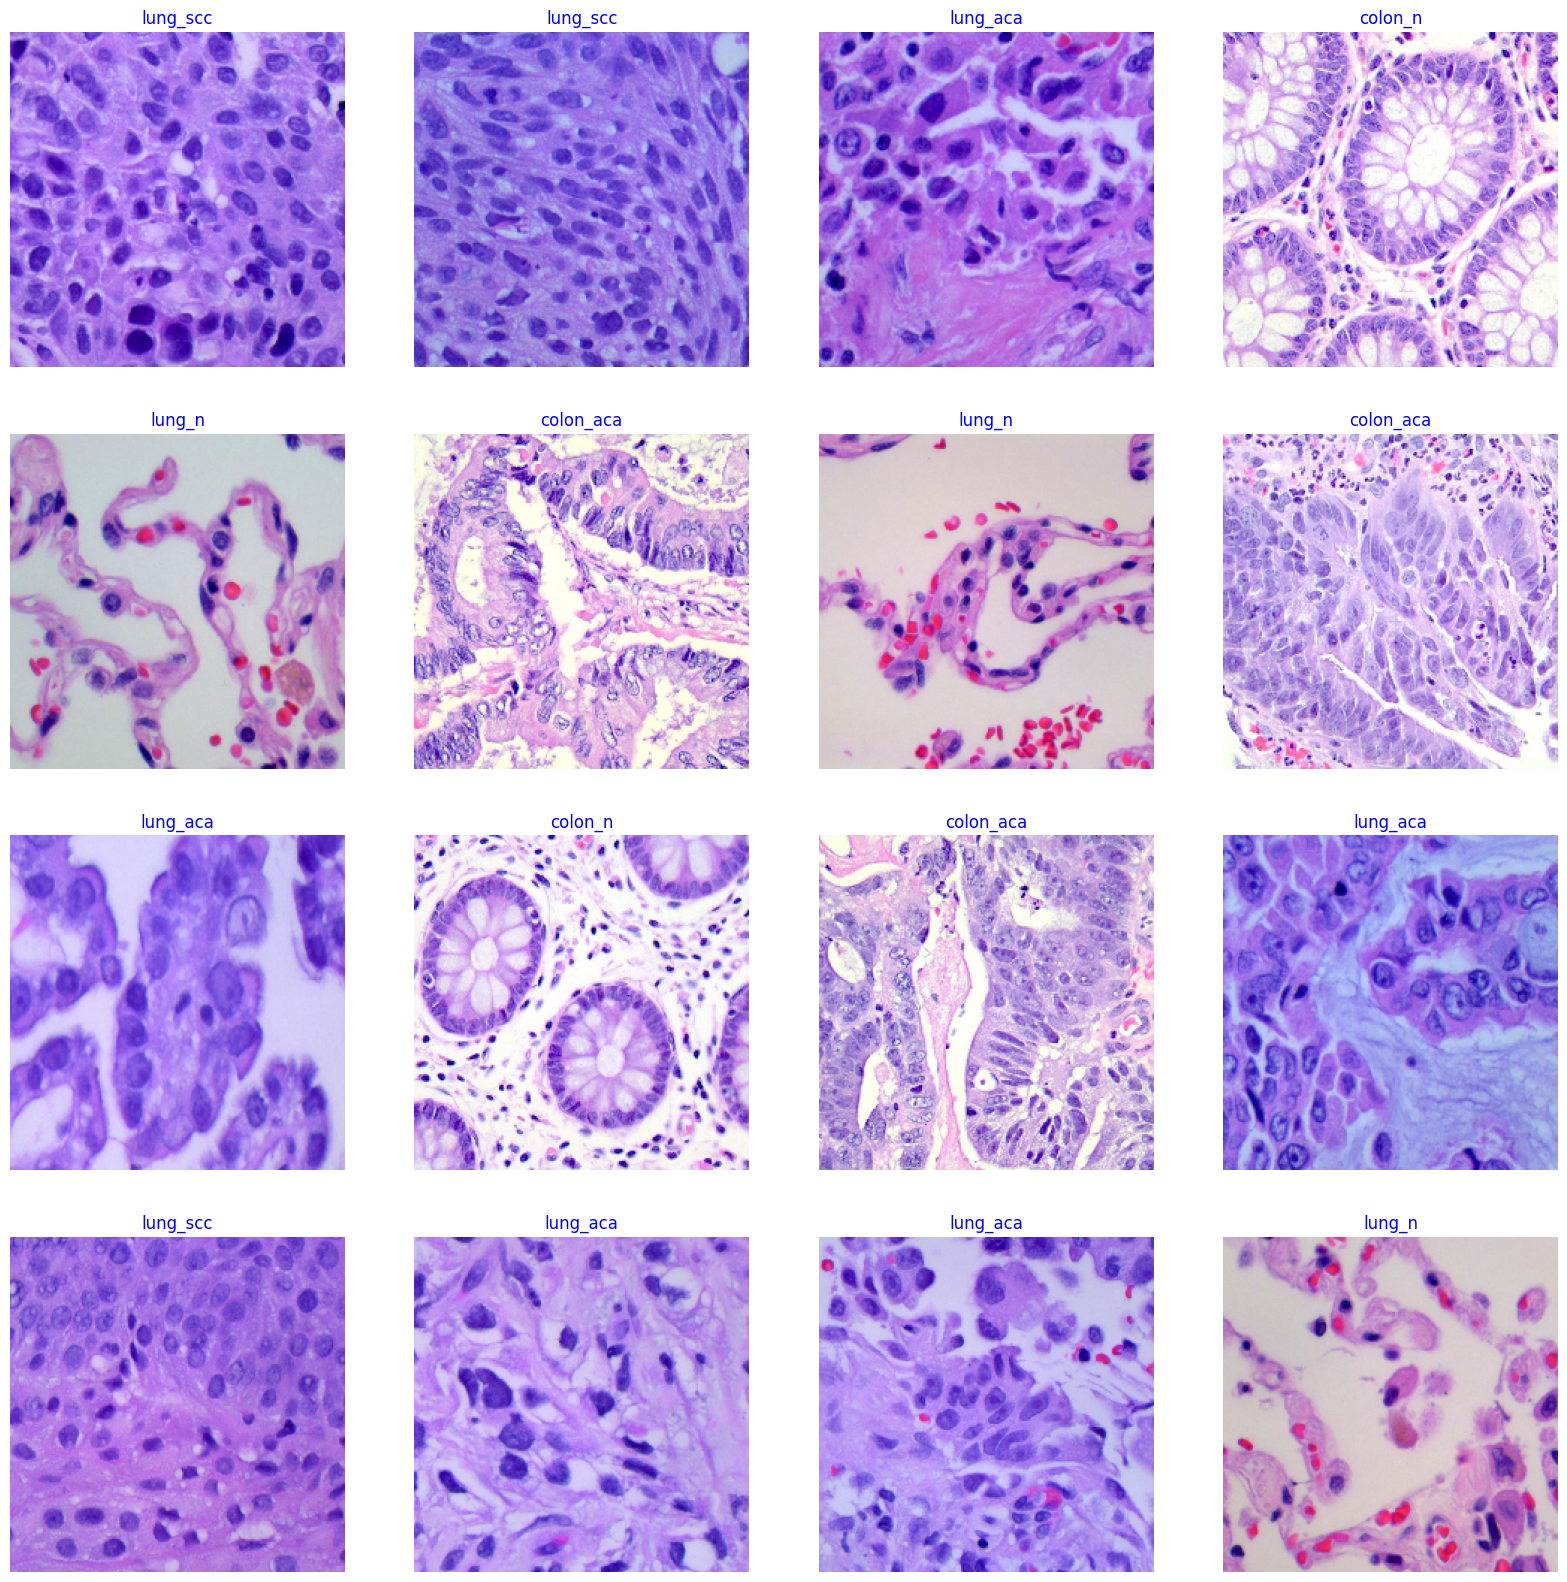

In [9]:
dict_gen = train_gen.class_indices # defines dictionary {'class': index}
classes = list(dict_gen.keys()) #define list of dictionary that have the names of the classes in the train data
images, labels = next(train_gen) #get batch size sample from train generator

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255 # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i]) # get image index
    class_name = classes[index] # get class of image
    plt.title(class_name , color= 'blue' , fontsize = 12)
    plt.axis('off')
plt.show();

## ResNet50

In [13]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(512, activation='relu'))
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dense(5, activation='softmax'))

In [14]:
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet = model_resnet.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10
313/313 [==============================] - 266s 714ms/step - loss: 0.5050 - accuracy: 0.9322 - val_loss: 0.2522 - val_accuracy: 0.9292
Epoch 2/10
313/313 [==============================] - 222s 707ms/step - loss: 0.0600 - accuracy: 0.9809 - val_loss: 0.1040 - val_accuracy: 0.9724
Epoch 3/10
313/313 [==============================] - 222s 709ms/step - loss: 0.0489 - accuracy: 0.9837 - val_loss: 2.1943 - val_accuracy: 0.6684
Epoch 4/10
313/313 [==============================] - 222s 709ms/step - loss: 0.0322 - accuracy: 0.9894 - val_loss: 2.2457 - val_accuracy: 0.7008
Epoch 5/10
313/313 [==============================] - 222s 709ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 5.2872 - val_accuracy: 0.5504
Epoch 6/10
313/313 [==============================] - 222s 708ms/step - loss: 0.2847 - accuracy: 0.9230 - val_loss: 78.8964 - val_accuracy: 0.6732
Epoch 7/10
313/313 [==============================] - 220s 704ms/step - loss: 0.1282 - accuracy: 0.9492 - val_loss: 0.2144 

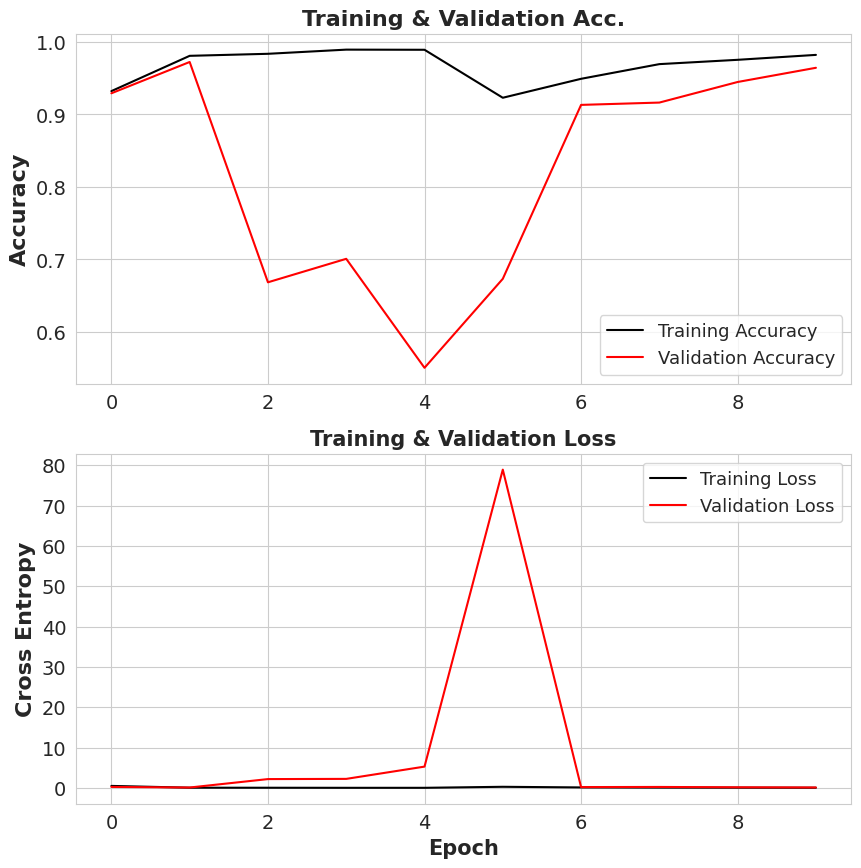

In [15]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='black')
plt.plot(val_acc, label='Validation Accuracy', color='red')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='black')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

## InceptionV3


In [16]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_inception = Sequential()
model_inception.add(base_model_inception)
model_inception.add(Flatten())
model_inception.add(Dense(512, activation='relu'))
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dense(5, activation='softmax'))

87910968/87910968 [==============================] - 5s 0us/step


In [17]:
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_inception = model_inception.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10
313/313 [==============================] - 201s 524ms/step - loss: 0.7683 - accuracy: 0.7411 - val_loss: 0.7955 - val_accuracy: 0.7716
Epoch 2/10
313/313 [==============================] - 156s 498ms/step - loss: 0.0851 - accuracy: 0.9709 - val_loss: 0.0253 - val_accuracy: 0.9916
Epoch 3/10
313/313 [==============================] - 158s 504ms/step - loss: 0.0516 - accuracy: 0.9832 - val_loss: 0.1350 - val_accuracy: 0.9592
Epoch 4/10
313/313 [==============================] - 158s 503ms/step - loss: 0.0479 - accuracy: 0.9836 - val_loss: 0.0791 - val_accuracy: 0.9744
Epoch 5/10
313/313 [==============================] - 157s 500ms/step - loss: 0.0339 - accuracy: 0.9895 - val_loss: 0.0378 - val_accuracy: 0.9852
Epoch 6/10
313/313 [==============================] - 157s 501ms/step - loss: 0.0187 - accuracy: 0.9936 - val_loss: 0.0623 - val_accuracy: 0.9808
Epoch 7/10
313/313 [==============================] - 156s 498ms/step - loss: 0.0768 - accuracy: 0.9811 - val_loss: 5534922.

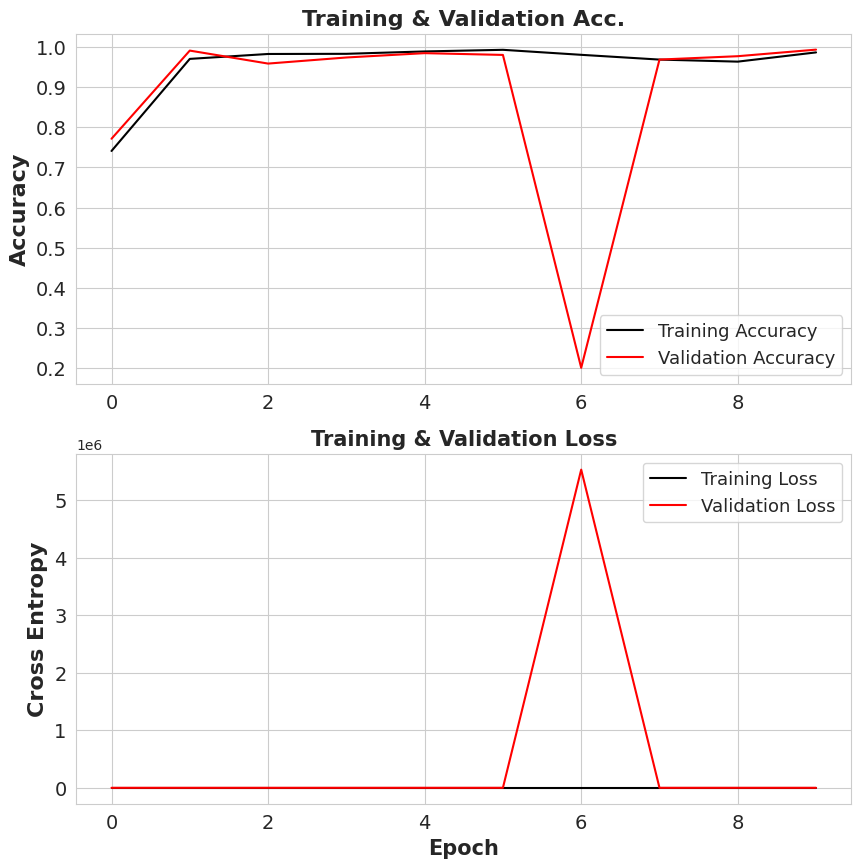

In [18]:
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='black')
plt.plot(val_acc, label='Validation Accuracy', color='red')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='black')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()